# Importing Libraires

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import os 
import cv2 
from PIL import Image
from tqdm.auto import tqdm 
import glob as gb 


import torch 
import torch.nn as nn 
import torch.nn.functional as F 
from torch.optim import Adam , lr_scheduler 
import torchvision 
from torchvision import datasets 
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader , Dataset
from torchmetrics import ConfusionMatrix 
from mlxtend.plotting import plot_confusion_matrix

from sklearn.metrics import accuracy_score , precision_score , recall_score , f1_score 

# Loading the dataset

In [2]:
def walk_through_data(dir_path) : 
    for dirpath , dirnames , filenames in tqdm(os.walk(dir_path)) : 
        print(f"There are {len(dirnames)} directions and {len(filenames)} images in {dirpath}")

In [3]:
train_path = '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
test_path = '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'
pred_path = '/kaggle/input/new-plant-diseases-dataset/test'

In [4]:
walk_through_data(train_path)

0it [00:00, ?it/s]

There are 38 directions and 0 images in /kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train
There are 0 directions and 1851 images in /kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Tomato___Late_blight
There are 0 directions and 1926 images in /kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Tomato___healthy
There are 0 directions and 1692 images in /kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Grape___healthy
There are 0 directions and 2010 images in /kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Orange___Haunglongbing_(Citrus_greening)
There are 0 directions and 2022 images in /kaggle/input/new-plant-diseases-dataset

In [5]:
walk_through_data(test_path)

0it [00:00, ?it/s]

There are 38 directions and 0 images in /kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid
There are 0 directions and 463 images in /kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid/Tomato___Late_blight
There are 0 directions and 481 images in /kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid/Tomato___healthy
There are 0 directions and 423 images in /kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid/Grape___healthy
There are 0 directions and 503 images in /kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid/Orange___Haunglongbing_(Citrus_greening)
There are 0 directions and 505 images in /kaggle/input/new-plant-diseases-dataset/New 

In [6]:
walk_through_data(pred_path)

0it [00:00, ?it/s]

There are 1 directions and 0 images in /kaggle/input/new-plant-diseases-dataset/test
There are 0 directions and 33 images in /kaggle/input/new-plant-diseases-dataset/test/test


In [7]:
extension=[]
classes = [] 

for folder in tqdm(os.listdir(train_path)) : 
    
    if folder not in classes : 
        classes.append(folder) 
        
    for file in os.listdir(train_path + "/" + folder + "/") : 
        if os.path.isfile(train_path + "/" + folder + "/" + file) : 
            extension.append(os.path.splitext(file)[1])

  0%|          | 0/38 [00:00<?, ?it/s]

In [8]:
print(len(extension) , np.unique(extension))

70295 ['.JPG' '.jpg']


In [9]:
len(classes)

38

In [10]:
dataset_labels = {key : value for value , key in enumerate(classes)}
dataset_labels

{'Tomato___Late_blight': 0,
 'Tomato___healthy': 1,
 'Grape___healthy': 2,
 'Orange___Haunglongbing_(Citrus_greening)': 3,
 'Soybean___healthy': 4,
 'Squash___Powdery_mildew': 5,
 'Potato___healthy': 6,
 'Corn_(maize)___Northern_Leaf_Blight': 7,
 'Tomato___Early_blight': 8,
 'Tomato___Septoria_leaf_spot': 9,
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 10,
 'Strawberry___Leaf_scorch': 11,
 'Peach___healthy': 12,
 'Apple___Apple_scab': 13,
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 14,
 'Tomato___Bacterial_spot': 15,
 'Apple___Black_rot': 16,
 'Blueberry___healthy': 17,
 'Cherry_(including_sour)___Powdery_mildew': 18,
 'Peach___Bacterial_spot': 19,
 'Apple___Cedar_apple_rust': 20,
 'Tomato___Target_Spot': 21,
 'Pepper,_bell___healthy': 22,
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 23,
 'Potato___Late_blight': 24,
 'Tomato___Tomato_mosaic_virus': 25,
 'Strawberry___healthy': 26,
 'Apple___healthy': 27,
 'Grape___Black_rot': 28,
 'Potato___Early_blight': 29,
 'Cherry_(inclu

In [11]:
def getlabel(n) : 
    for x , y in dataset_labels.items() : 
        if n==y : 
            return x

In [12]:
img_size = 224

In [13]:
train_path_list=[]
train_labels=[] 

for folder in tqdm(os.listdir(train_path)) : 
    files = gb.glob(pathname = str(train_path + "/" + folder + "/*.JPG")) + gb.glob(pathname = str(train_path + "/" + folder + "/*.jpg"))
    for file in files : 
        train_path_list.append(file) 
        train_labels.append(dataset_labels[folder])

  0%|          | 0/38 [00:00<?, ?it/s]

In [14]:
len(train_path_list) , len(train_labels) 

(70295, 70295)

In [15]:
test_path_list = [] 
test_labels = [] 

for folder in tqdm(os.listdir(test_path)) : 
    files = gb.glob(pathname = str(test_path + "/" + folder + "/*.JPG")) + gb.glob(pathname = str(test_path + "/" + folder + "/*.jpg"))
    for file in files : 
        test_path_list.append(file)
        test_labels.append(dataset_labels[folder])

  0%|          | 0/38 [00:00<?, ?it/s]

In [16]:
len(test_path_list) , len(test_labels) 

(17572, 17572)

In [17]:
preds_path_list = [] 

for folder in tqdm(os.listdir(pred_path)) : 
    files = gb.glob(pathname = str(pred_path + "/" + folder + "/*.JPG")) + gb.glob(pathname = str(pred_path + "/" + folder + "/*.jpg"))
    for file in files : 
        preds_path_list.append(file)

  0%|          | 0/1 [00:00<?, ?it/s]

In [18]:
len(preds_path_list)

33

# Turning our data into tensors

In [19]:
basic_transform = transforms.Compose([
    transforms.Resize(size = (img_size , img_size)) , 
    transforms.ToTensor()
])

In [20]:
class InvalidDatasetException(Exception):
    
    def __init__(self,len_of_paths,len_of_labels):
        super().__init__(
            f"Number of paths ({len_of_paths}) is not compatible with number of labels ({len_of_labels})"
        )

In [21]:
class train_data(Dataset) : 
    def __init__(self , train_path , train_label , transform_method) : 
        self.train_path = train_path 
        self.train_label = train_label 
        self.transform = transform_method 
        if len(self.train_path) != len(self.train_label):
            raise InvalidDatasetException(self.train_path,self.train_label)
            
    
    def __len__(self) : 
        return len(self.train_path)
    
    
    def __getitem__(self , index) : 
        image = Image.open(self.train_path[index])
        tensor_image = self.transform(image)
        label = self.train_label[index]
        
        return tensor_image , label 

In [22]:
train_set = train_data(train_path_list , train_labels , basic_transform)

In [23]:
np.unique(train_set.train_label)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37])

In [24]:
print(f"The number of images in the train set is : {train_set.__len__()}")

The number of images in the train set is : 70295


In [25]:
filer_train_image=train_set.__getitem__(1000)

In [26]:
filer_train_image[0].shape

torch.Size([3, 224, 224])

In [27]:
getlabel(filer_train_image[1])

'Tomato___Late_blight'

In [28]:
class test_data(Dataset) : 
    def __init__(self, test_path ,test_label , transform_method) : 
        self.test_path = test_path 
        self.test_label = test_label 
        self.transform = transform_method 
        if len(self.test_path) != len(self.test_label):
            raise InvalidDatasetException(self.test_path,self.test_label)
            
    def __len__(self) : 
        return len(self.test_path)
    
    
    def __getitem__(self , index) : 
        image = Image.open(self.test_path[index])
        tensor_image = self.transform(image)
        label = self.test_label[index]
        
        return tensor_image , label 
            

In [29]:
test_set = test_data(test_path_list , test_labels , basic_transform)

In [30]:
np.unique(test_set.test_label)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37])

In [31]:
print(f"The number of images in the test set is : {test_set.__len__()}")

The number of images in the test set is : 17572


In [32]:
filer_test_image = test_set.__getitem__(200)

In [33]:
filer_test_image[0].shape

torch.Size([3, 224, 224])

In [34]:
getlabel(filer_test_image[1])

'Tomato___Late_blight'

In [35]:
class pred_data(Dataset) : 
    def __init__(self, pred_path , transform_method) : 
        self.pred_path = pred_path 
        self.transform = transform_method 
        
        
    def __len__(self) : 
        return len(self.pred_path)
    
    
    def __getitem__(self , index) : 
        image = Image.open(self.pred_path[index])
        tensor_image = self.transform(image)
        
        return tensor_image 

In [36]:
pred_set = pred_data(preds_path_list , basic_transform)

In [37]:
print(f"The number of images in the pred set is : {pred_set.__len__()}")

The number of images in the pred set is : 33


In [38]:
filer_pred_image = pred_set.__getitem__(15)

In [39]:
filer_pred_image.shape

torch.Size([3, 224, 224])

In [40]:
BATCH_SIZE = 128 

# Create dataloaders for our train , test and pred data 

In [41]:
torch.manual_seed(42) 
train_dataloader = DataLoader(
    dataset = train_set , 
    batch_size = BATCH_SIZE , 
    shuffle = True 
)

In [42]:
torch.manual_seed(42) 
test_dataloader = DataLoader(
    dataset = test_set , 
    batch_size = BATCH_SIZE , 
    shuffle = False 
)

In [43]:
torch.manual_seed(42)
pred_dataloader = DataLoader(
    dataset = pred_set , 
    batch_size = pred_set.__len__() , 
    shuffle = False
)

In [44]:
print(f"the size of the train dataloader {len(train_dataloader)} batches of {BATCH_SIZE}")

the size of the train dataloader 550 batches of 128


In [45]:
trainimage_sample , trainlabel_sample = next(iter(train_dataloader))
trainimage_sample.shape , trainlabel_sample.shape

(torch.Size([128, 3, 224, 224]), torch.Size([128]))

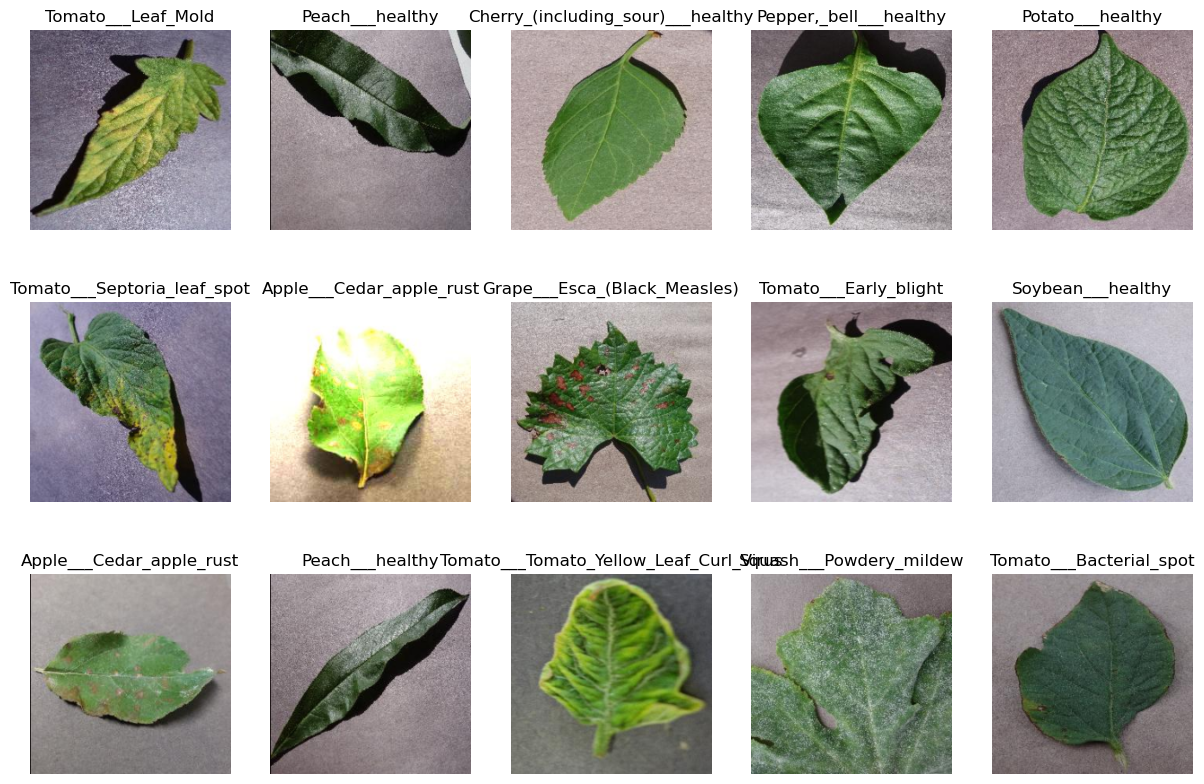

In [46]:
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        img = trainimage_sample[i].numpy()
        img = np.transpose(img, (1, 2, 0))
        ax.imshow(img)
        ax.set(title = f"{getlabel(trainlabel_sample[i])}")
        ax.axis('off')

In [47]:
print(f"the size of the test dataloader {len(test_dataloader)} batches of {BATCH_SIZE}")

the size of the test dataloader 138 batches of 128


In [48]:
testimage_sample , testlabel_sample = next(iter(test_dataloader))
testimage_sample.shape , testlabel_sample.shape 

(torch.Size([128, 3, 224, 224]), torch.Size([128]))

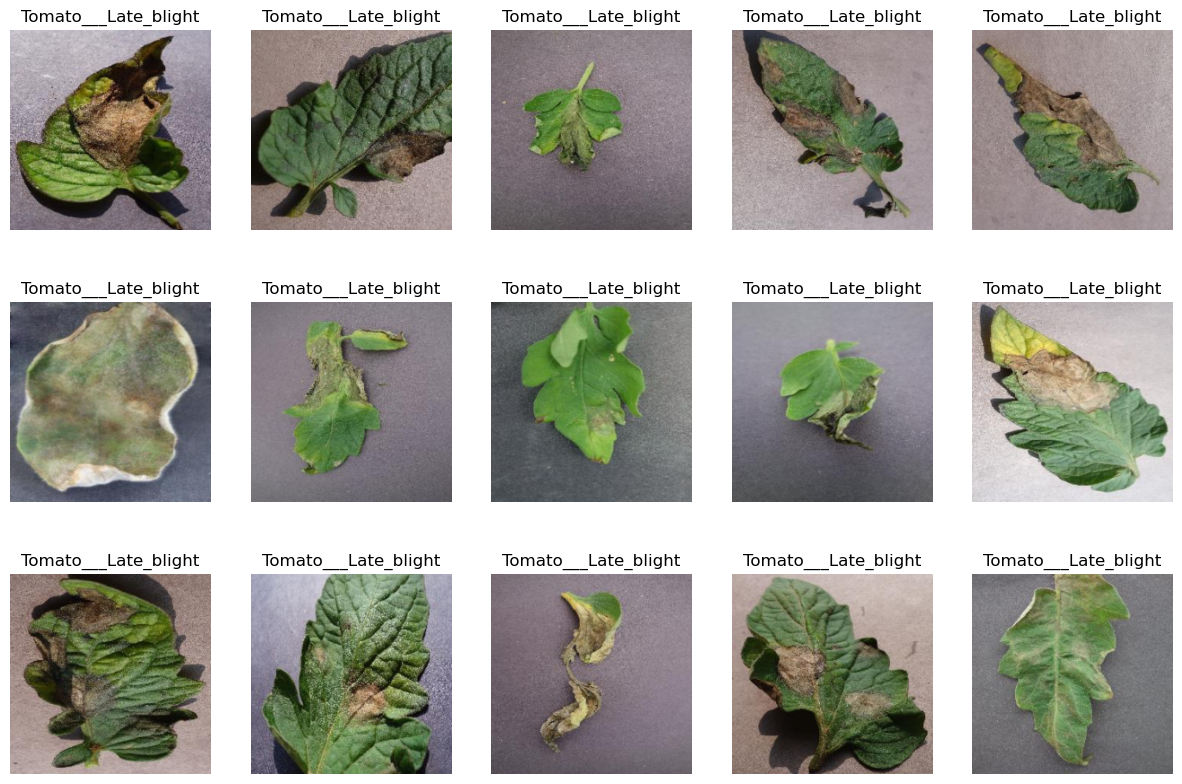

In [49]:
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        img = testimage_sample[i].numpy()
        img = np.transpose(img, (1, 2, 0))
        ax.imshow(img)
        ax.set(title = f"{getlabel(testlabel_sample[i])}")
        ax.axis('off')

In [50]:
print(f"the size of the pred dataloader {len(pred_dataloader)}")

the size of the pred dataloader 1


In [51]:
predimage_sample = next(iter(pred_dataloader))
predimage_sample.shape

torch.Size([33, 3, 224, 224])

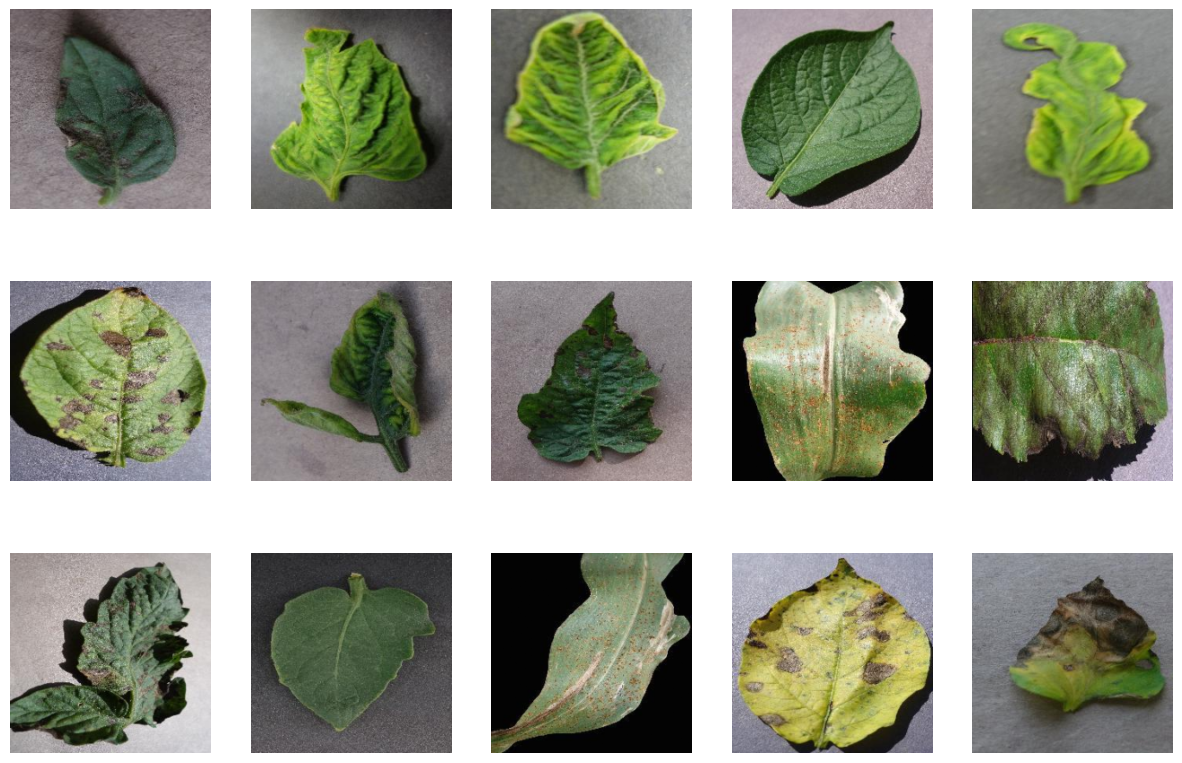

In [52]:
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        img = predimage_sample[i].numpy()
        img = np.transpose(img, (1, 2, 0))
        ax.imshow(img)
        ax.axis('off')

In [54]:
def param_count(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    print('Total number of parameters : ', sum(params))

# Build the model 

In [55]:
class CNN(nn.Module) : 
    def __init__(self,input_shape , output) : 
        super().__init__()
        self.block1=nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape , 
                out_channels=32 , 
                kernel_size=(3,3) , 
                stride=2 , 
                padding = 1 
            ) , 
            
            nn.ReLU() , 
            
            nn.Conv2d(
                in_channels=32 , 
                out_channels=64 , 
                kernel_size=(3,3) , 
                stride=2 , 
                padding=1 
            ) , 
            
            nn.ReLU() , 
            
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.block2=nn.Sequential(
            nn.Conv2d(
                in_channels=64 , 
                out_channels=128 , 
                kernel_size=(3,3) , 
                stride = 2 , 
                padding = 1 
            ) , 
            
            nn.ReLU() , 
            
            nn.Conv2d(
                in_channels=128 , 
                out_channels=256 , 
                kernel_size = (3,3) , 
                stride = 2 , 
                padding = 1 
            ) ,
            
            nn.ReLU() , 
            
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.fully_connected_layer=nn.Sequential(
            nn.Flatten() , 
            nn.Linear(in_features=256*3*3
                      , out_features=output)
        )
        
        
    def forward(self,x) : 
        x=self.block1(x) 
#         print(f"The output shape of conv block1 is : {x.shape}\n\n")
        x=self.block2(x) 
#         print(f"The output shape of conv block2 is : {x.shape}\n\n")
        x=self.fully_connected_layer(x)
        return x

In [56]:
torch.manual_seed(42)
model=CNN(
    input_shape = 3 , 
    output=len(classes)
)

In [57]:
model.parameters

<bound method Module.parameters of CNN(
  (block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fully_connected_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2304, out_features=38, bias=True)
  )
)>

In [58]:
param_count(model)

Total number of parameters :  476006


In [59]:
criterion=nn.CrossEntropyLoss()
optimizer=Adam(model.parameters(),lr=0.001)

# Training the model 

In [60]:
epochs = 10 
training_acc = [] 
training_loss = [] 

for i in tqdm(range(epochs)) : 
    epoch_loss = 0 
    epoch_acc = 0 
    
    for batch , (x_train , y_train) in enumerate(train_dataloader) : 
        y_pred = model.forward(x_train) 
        
        loss = criterion(y_pred , y_train) 
        
        if batch % 100 == 0:
            print(f"Looked at {batch * len(x_train)}/{len(train_dataloader.dataset)} samples.")
            
            
        loss.backward()
        optimizer.step()
        optimizer.zero_grad() 
        
        
        epoch_loss +=loss 
        epoch_acc += accuracy_score(y_train , y_pred.argmax(dim=1))
        
    training_loss.append((epoch_loss/len(train_dataloader)).detach().numpy())
    training_acc.append(epoch_acc/len(train_dataloader))
    
    print(f"Epoch {i}: Accuracy: {(epoch_acc/len(train_dataloader)) * 100}, Loss: {(epoch_loss/len(train_dataloader))}\n\n")

  0%|          | 0/10 [00:00<?, ?it/s]

Looked at 0/70295 samples.
Looked at 12800/70295 samples.
Looked at 25600/70295 samples.
Looked at 38400/70295 samples.
Looked at 51200/70295 samples.
Looked at 64000/70295 samples.
Epoch 0: Accuracy: 61.77562994071146, Loss: 1.31062650680542


Looked at 0/70295 samples.
Looked at 12800/70295 samples.
Looked at 25600/70295 samples.
Looked at 38400/70295 samples.
Looked at 51200/70295 samples.
Looked at 64000/70295 samples.
Epoch 1: Accuracy: 85.17150444664033, Loss: 0.47223660349845886


Looked at 0/70295 samples.
Looked at 12800/70295 samples.
Looked at 25600/70295 samples.
Looked at 38400/70295 samples.
Looked at 51200/70295 samples.
Looked at 64000/70295 samples.
Epoch 2: Accuracy: 89.26951581027667, Loss: 0.33450770378112793


Looked at 0/70295 samples.
Looked at 12800/70295 samples.
Looked at 25600/70295 samples.
Looked at 38400/70295 samples.
Looked at 51200/70295 samples.
Looked at 64000/70295 samples.
Epoch 3: Accuracy: 91.69361413043478, Loss: 0.25296422839164734


Looked at 0

In [61]:
print(f"The accuracy of the training set is : {(training_acc[-1] * 100):0.2f}%")
print(f"The loss of the training set is : {training_loss[-1]}")

The accuracy of the training set is : 96.65%
The loss of the training set is : 0.09812075644731522


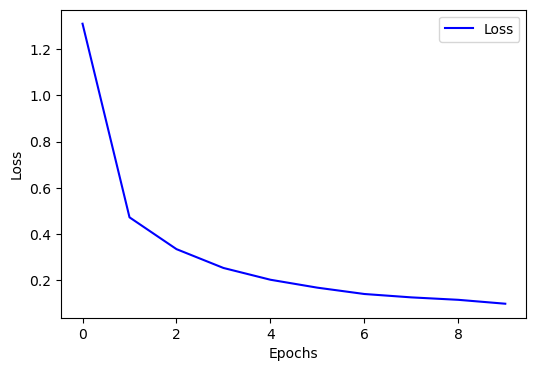

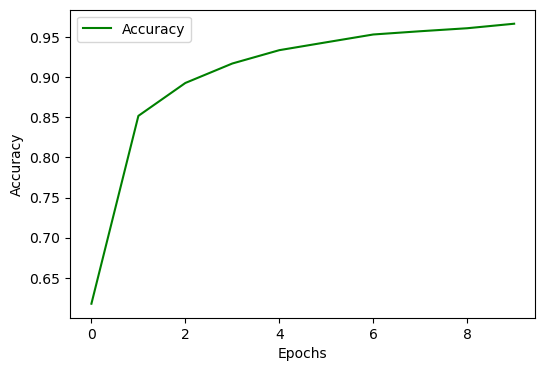

In [62]:
plt.subplots(figsize=(6,4))
plt.plot(range(epochs),training_loss,color="blue",label="Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.subplots(figsize=(6,4))
plt.plot(range(epochs),training_acc,color="green",label="Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluating the model 

In [63]:
test_loss=0
test_acc= 0
test_preds=[]
test_targets = []
torch.manual_seed(42)
with torch.no_grad() : 
        for x_test , y_test in test_dataloader : 
            y_pred=model.forward(x_test)
            test_pred = torch.softmax(y_pred , dim=1 ).argmax(dim=1)
            test_preds.append(test_pred)
            test_targets.extend(y_test)
            
            loss=criterion(y_pred,y_test)
            test_loss+=loss
            test_acc += accuracy_score(y_test , y_pred.argmax(dim=1))
            
            
test_loss/=len(test_dataloader)
test_acc/=len(test_dataloader)
test_preds = torch.cat(test_preds)
test_targets = torch.Tensor(test_targets)

In [64]:
print(f"The loss of the testing set is : {test_loss}\n")
print(f"The accuracy of the testing set is : {(test_acc*100):0.2f}%\n")

The loss of the testing set is : 0.2240951657295227

The accuracy of the testing set is : 93.23%



# Making predictions

In [65]:
y_preds = [] 

torch.manual_seed(42)
with torch.no_grad() : 
    for x  in pred_dataloader : 
        y_pred = model.forward(x) 
        
        y_pred = torch.softmax(y_pred , dim=1 ).argmax(dim=1)
        y_preds.append(y_pred)

In [66]:
y_preds = torch.cat(y_preds)

In [67]:
y_preds

tensor([35, 14, 14,  6, 14, 29,  8, 35, 31, 10,  8,  1, 31, 29,  0, 14, 31,  8,
        19,  1, 13,  1, 27, 20,  6, 14, 29, 20, 27,  8, 20, 29,  1])

In [68]:
x_preds_labels = [] 

for folder in tqdm(os.listdir(pred_path)) :     
    for file in os.listdir(pred_path + "/" + folder + "/") : 
        if os.path.isfile(pred_path + "/" + folder + "/" + file) : 
            x_preds_labels.append(os.path.splitext(file)[0])

  0%|          | 0/1 [00:00<?, ?it/s]

In [69]:
x_preds_samples = next(iter(pred_dataloader))
x_preds_samples.shape

torch.Size([33, 3, 224, 224])

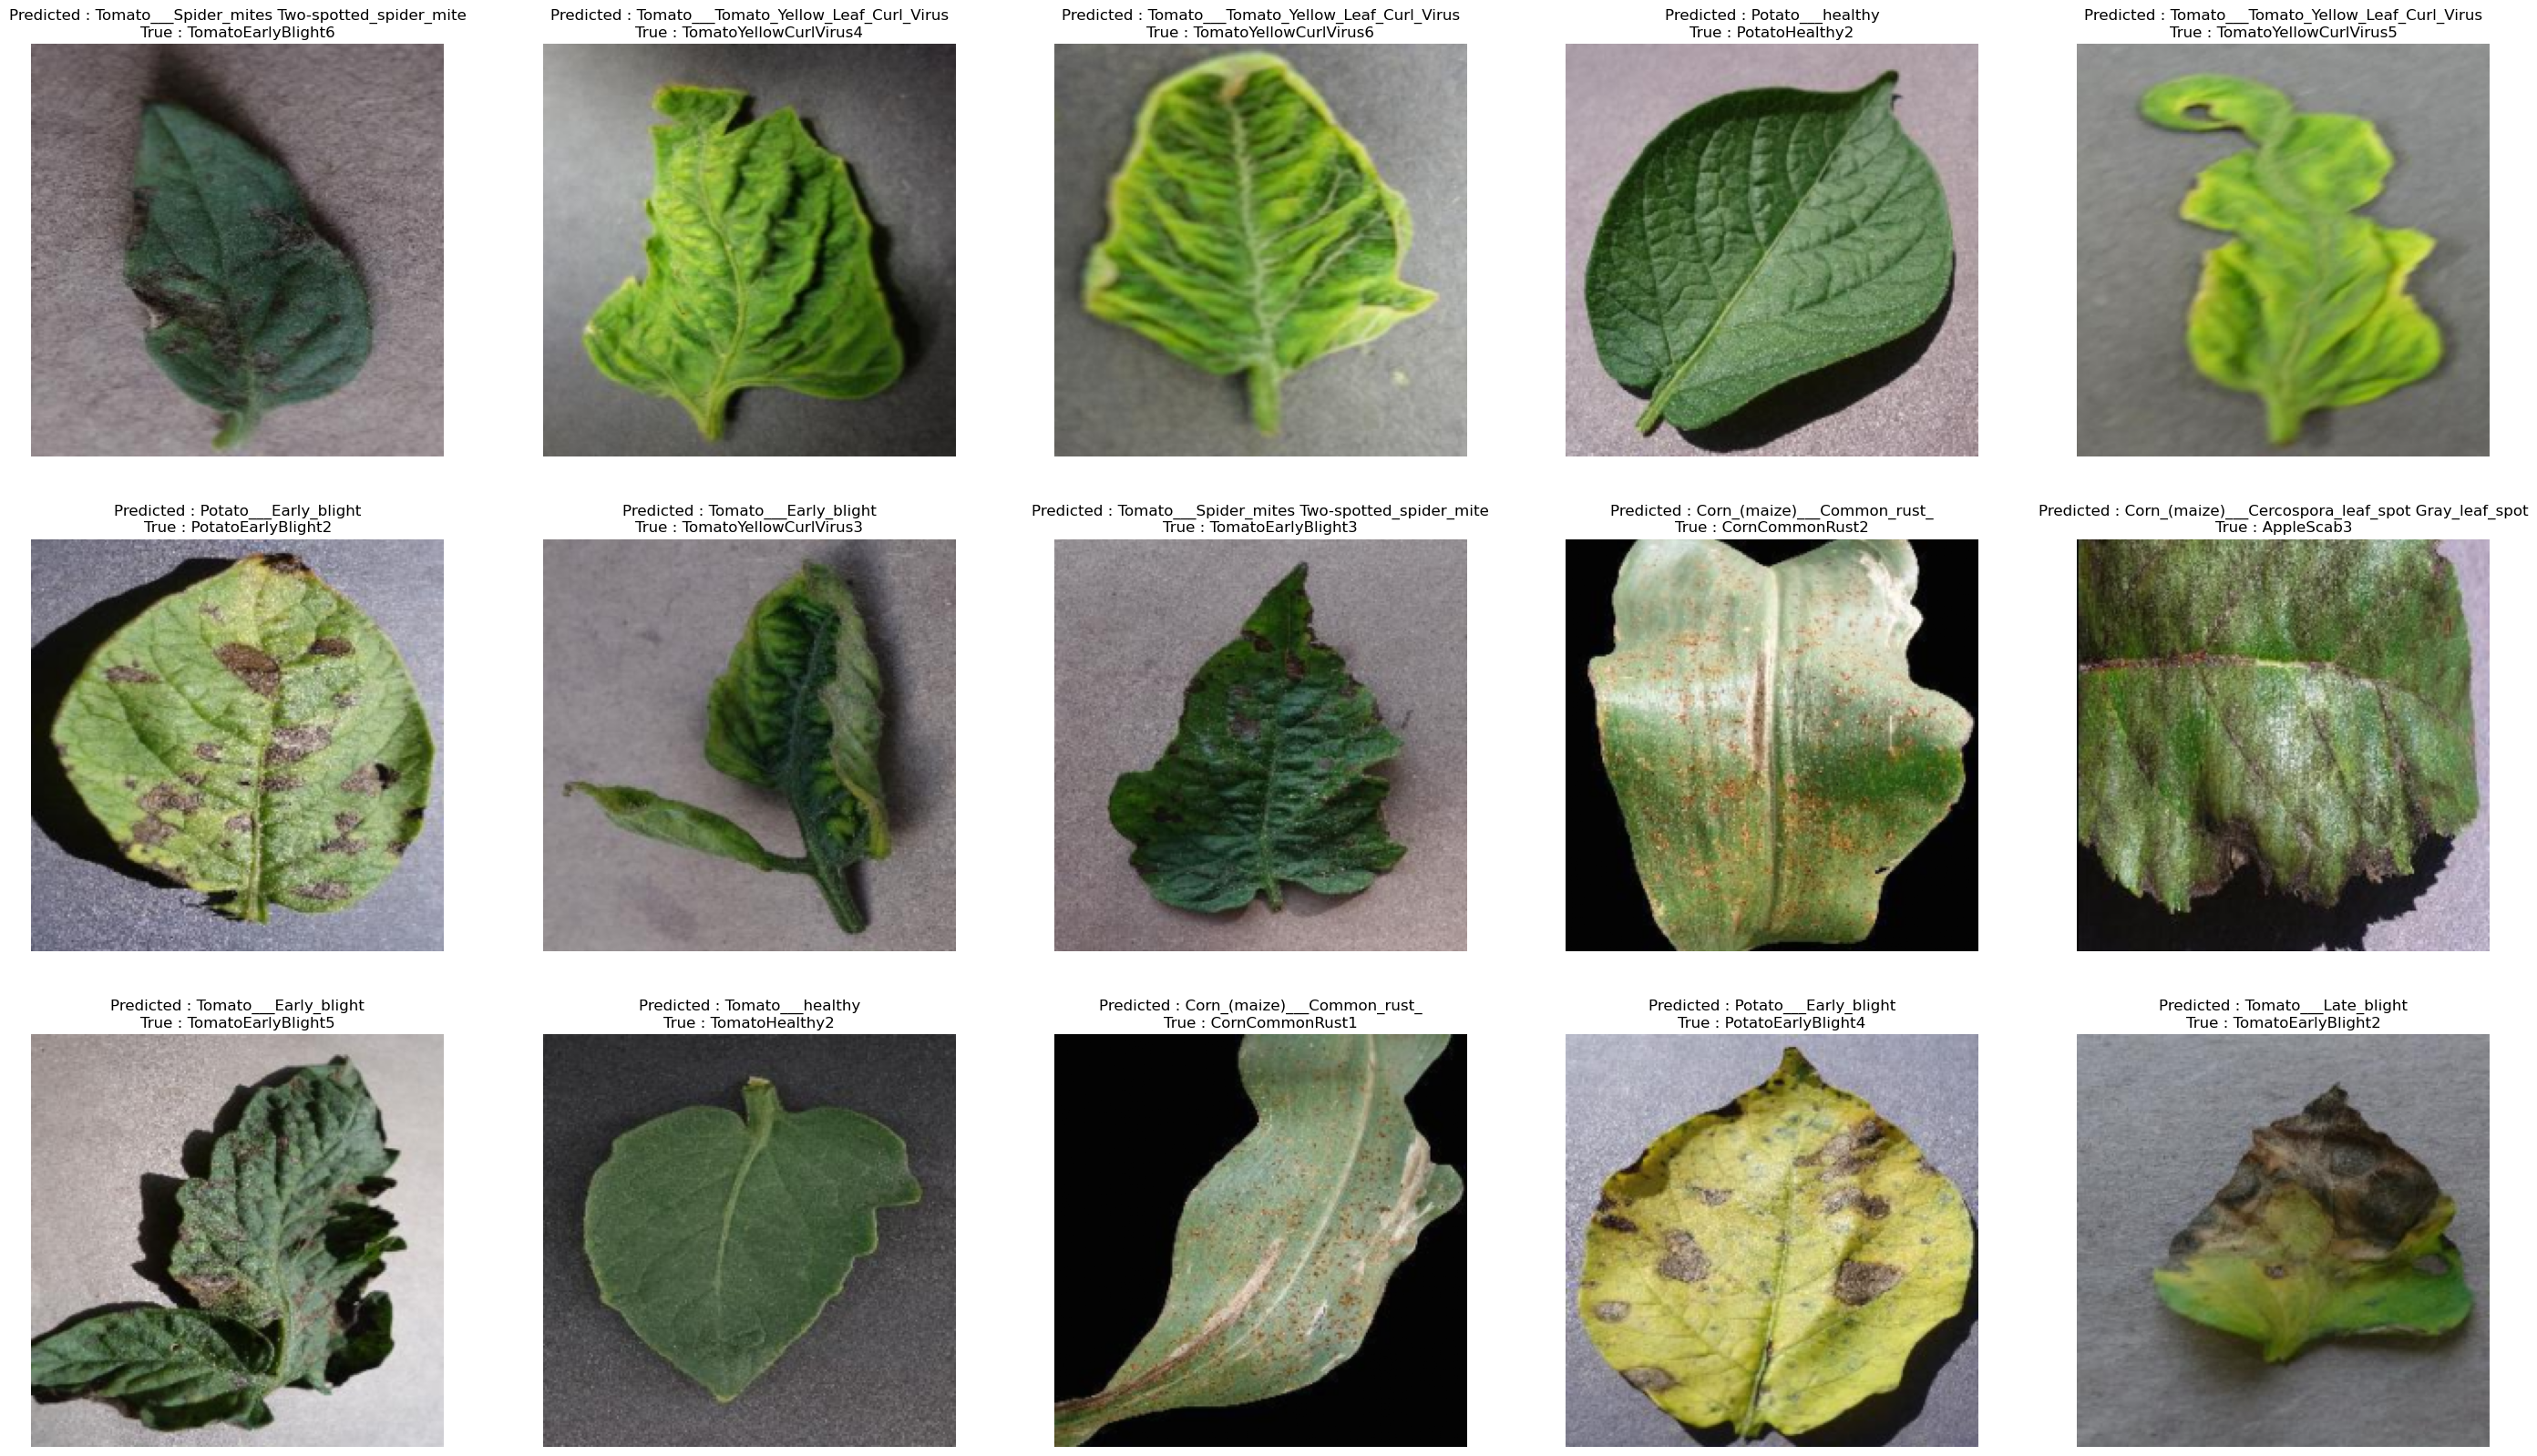

In [70]:
fig, axis = plt.subplots(3, 5, figsize=(35, 20))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        img = x_preds_samples[i].numpy()
        img = np.transpose(img, (1, 2, 0))
        ax.imshow(img)
        ax.set(title = f"Predicted : {getlabel(y_preds[i])}\nTrue : {x_preds_labels[i]}")
        ax.axis('off')

# Measuring performance 

In [71]:
print(f"The accuracy of the training set is : {(training_acc[-1] * 100):0.2f}%")
print(f"The accuracy of the testing set is : {(test_acc*100):0.2f}%\n")
print(f"\nRecall : {recall_score(test_targets,test_preds,average='weighted')}")
print(f"\nPrecision : {precision_score(test_targets,test_preds,average='weighted')}")
print(f"\nF1 Score {f1_score(test_targets,test_preds,average='weighted')}\n")

The accuracy of the training set is : 96.65%
The accuracy of the testing set is : 93.23%


Recall : 0.9319371727748691

Precision : 0.9330095852654324

F1 Score 0.931404154565216



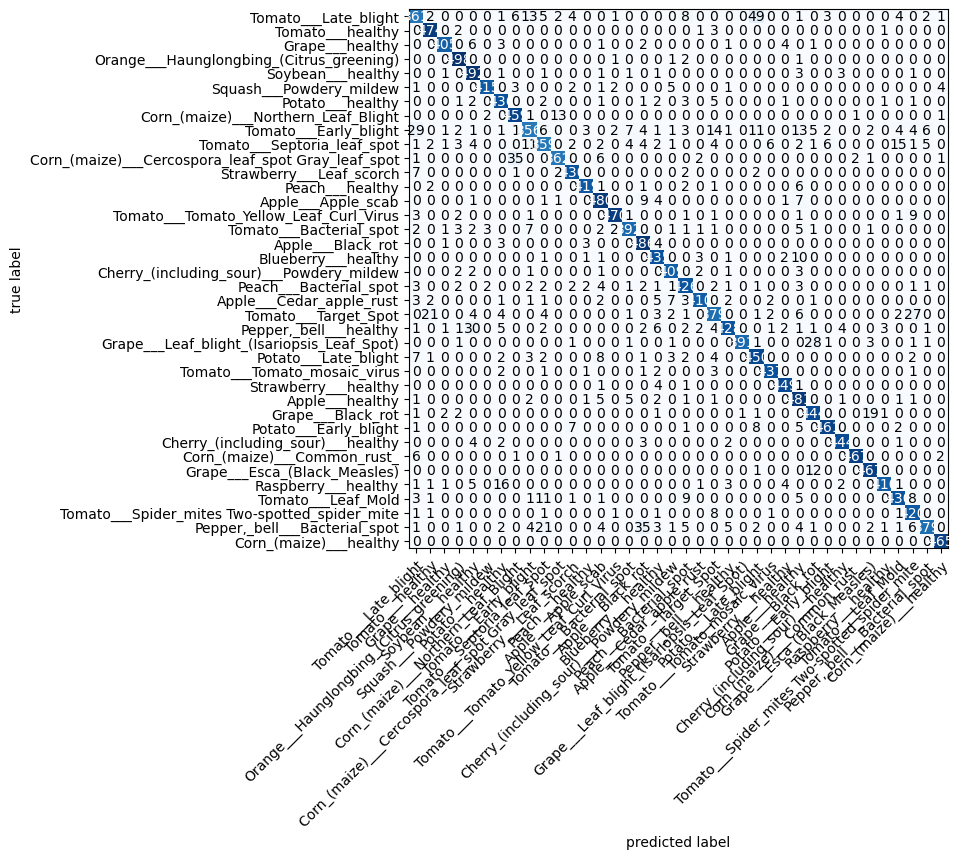

In [72]:
confmat = ConfusionMatrix(num_classes=len(classes), task='multiclass')
confmat_tensor = confmat(preds=test_preds,
                         target=test_targets)

fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=classes,
    figsize=(10, 7)
);

# Save our model 

In [73]:
torch.save(model.state_dict(), 'New_Plant_disease_classification.pt')